<a href="https://colab.research.google.com/github/UditKushwaha17/Variational_Auto_Encoder/blob/main/Variational_Auto_Encoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import keras
np.random. seed(123) # for reproducibility
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Layer, Input, Lambda
from keras. layers import Multiply, Add, BatchNormalization, Reshape
from keras. layers import UpSampling2D, Convolution2D, LeakyReLU, Flatten, ReLU
from tensorflow.keras.optimizers.legacy import Adam
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from keras.datasets import mnist
from keras import backend as K
from scipy.stats import norm

import matplotlib.image as mpimg
import sys

from tqdm import tqdm_notebook
from IPython import display
%matplotlib inline

In [ ]:
from keras import backend as K
from keras.optimizers import Adam
from keras.layers import Conv2D

In [ ]:
original_dim = 784
(x_train, y_train), (x_test, y_test) = mnist. load_data()
x_train = x_train.reshape(-1, original_dim) / 255.
x_test = x_test.reshape(-1, original_dim) / 255.

11490434/11490434 [==============================] - 1s 0us/step


In [ ]:
from keras import backend as K
from keras.optimizers import Adam
from keras.layers import Conv2D
def nll(y_true, y_pred):
  """Negative log likelihood (Bernoulli). """

  # keras. losses.binary_crossentropy gives the mean
  # over the last axis. we require the sum
  return K.sum(K.binary_crossentropy(y_true, y_pred), axis =- 1)

class KLDivergenceLayer(Layer):

  """ Identity transform layer that adds KL divergence
  to the final model loss.
  """
  def _init_(self, *args, ** kwargs):
    self.is_placeholder = True
    super(KLDivergenceLayer, self) .__init__(*args, ** kwargs)
  def call(self, inputs):
    mu, log_var = inputs
    kl_batch = - .5 * K.sum(1 + log_var -
                            K.square(mu) -
                            K.exp(log_var), axis =- 1)
    self.add_loss(K.mean(kl_batch), inputs=inputs)

    return inputs

In [ ]:
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
latent_dim=2
x = tf.keras.Input(shape = (original_dim,))
h = Reshape((28, 28, 1))(x)
h = Conv2D(64, kernel_size=(5, 5), strides=(2, 2), padding='same' ) (h)
h = LeakyReLU(0.2)(h)
h = Conv2D(128, kernel_size=(5, 5), strides=(2, 2), padding='same' ) (h)
h = LeakyReLU(0.2)(h)
h = Flatten()(h)
z_mu = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)
z_mu, z_log_var = KLDivergenceLayer()([z_mu, z_log_var])

In [ ]:

##### Reparametrisation trick

## Log_var to sigma

z_sigma = Lambda(lambda t: K.exp(.5*t))(z_log_var)

## Sample using normal distribution

eps = tf.keras. Input(tensor=K.random_normal(shape=(K.shape(x)[0], latent_dim)))

## Multiply by sigma

z_eps = Multiply()([z_sigma, eps])

## Add mu

z = Add() ([z_mu, z_eps])

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.initializers import RandomNormal

# Create the decoder model
decoder = Sequential()
decoder.add(Dense(128*7*7, input_dim=latent_dim, kernel_initializer=RandomNormal(stddev=0.02)))
decoder.add(LeakyReLU(0.2))
decoder.add(Reshape((7, 7, 128)))
decoder.add(UpSampling2D(size=(2, 2)))
decoder.add(Conv2D(64, kernel_size=(5, 5), padding='same'))
decoder.add(LeakyReLU(0.2))
decoder.add(UpSampling2D(size=(2, 2)))
decoder.add(Conv2D(1, kernel_size=(5, 5), padding='same', activation='sigmoid'))
decoder.add(Flatten())

# Get the model's prediction
x_pred = decoder(z)

In [ ]:
vae = Model(inputs=[x, eps], outputs=x_pred)
vae.compile(optimizer ='adam', loss= nll)

In [ ]:
epochs =1
batch_size =50
vae.fit(x_train,
        x_train,
        shuffle =True,
        epochs = epochs,

        batch_size=batch_size,
        validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
60000/60000 [==============================] - ETA: 0s - loss: 173.3486

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


60000/60000 [==============================] - 700s 12ms/sample - loss: 173.3486 - val_loss: 161.7691


The MSE is: 0.0466


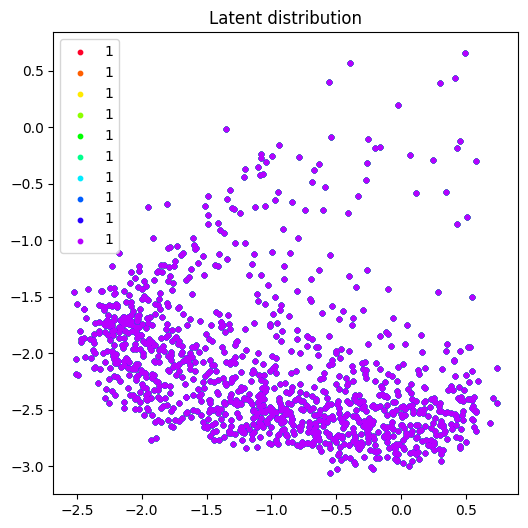

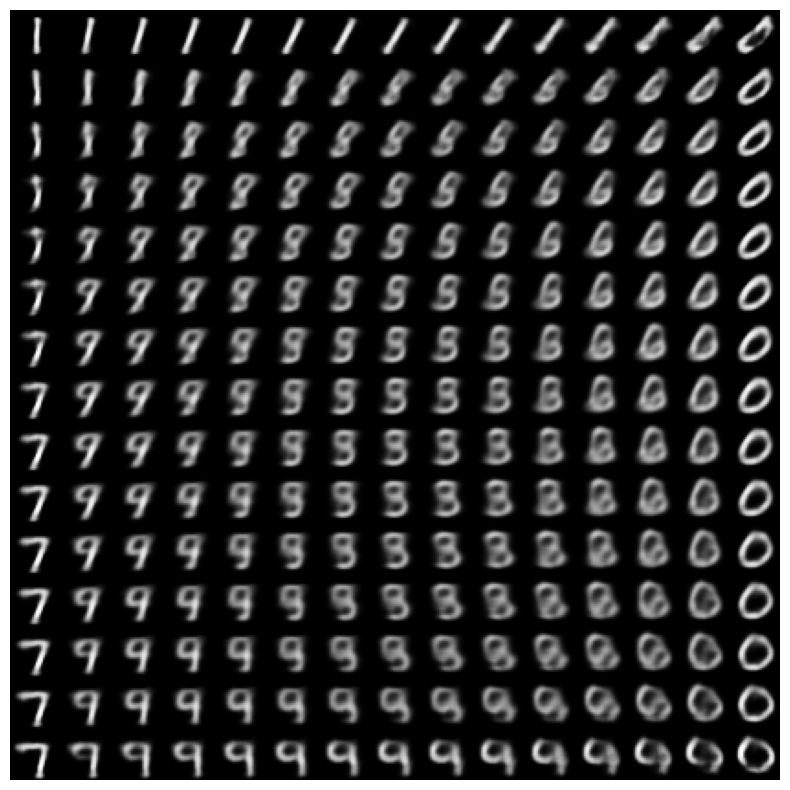

In [ ]:
encoder = Model(x, z_mu)
z_test = encoder.predict(x_test, batch_size=batch_size)
images = decoder.predict(z_test)
print("The MSE is: {:.4f}".format(((images-x_test)**2).mean()))
encoder = Model(x, z_mu)

# display a 2D plot of the digit classes in the latent space
z_test = encoder.predict(x_test, batch_size=batch_size)
fig, ax = plt.subplots(figsize=(6,6))
cm = plt.get_cmap('gist_rainbow')
ax.set_prop_cycle(color=[cm(1.* i/(10)) for i in range(10)])
for l in range(10):
# Only select indices for corresponding label
  ind = y_test == 1
  ax.scatter(z_test[ind, 0], z_test[ind, 1], label=str(1), s=10)
ax.legend()
plt.title("Latent distribution")
plt.show()
# display a 2D manifold of the digits
n = 15 # figure with 15x15 digits
digit_size = 28

# linearly spaced coordinates on the unit square were transformed
# through the inverse CDF (pof) of the Gaussian to produce values
# of the latent variables z, since the prior of the latent space
# is Gaussian

z1 = norm.ppf(np.linspace(0.01, 0.99, n))
z2 = norm.ppf(np.linspace(0.01, 0.99, n))
z_grid = np.dstack(np.meshgrid(z1, z2))

x_pred_grid = decoder.predict(z_grid.reshape(n*n, latent_dim)) \
                     .reshape(n, n, digit_size, digit_size)

plt.figure(figsize=(10, 10))
plt.imshow(np.block(list(map(list, x_pred_grid))), cmap='gray')
plt.axis('off')
plt.show()